In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Copy the dataset from Google Drive to local

!cp "/content/drive/MyDrive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [7]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

# Data pre-processing

In [8]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:

1. Import the training and testing data from numpy arrays

2. Remove the images and labels related to baseline patches (even indices in the arrays)

3. Adjust the labels for the classification problem, so that 0 corresponds to 'benign mass', 1 to 'malignant mass', 2 to 'bening calcification' and 3 to 'malignant calcification'

4. Convert the labels to categorical format, required by the categorical_crossentropy loss function

5. Normalize the pixels to be in the range (0-1) floating point

6. Shuffle the training set (and labels accordingly, of course)

7. Split the training data into 'training' and 'validation' subsets

8. Build Keras generators for training and validation data. Note that data augmentation is used from the beginning, as its value was proven in the previous notebook (Scratch_CNN_2_class)

In [9]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


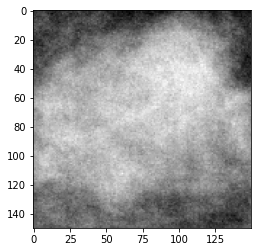

Label: [0. 1. 0. 0.]


In [10]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# Experiment 3


What about another convolutional block? Does it help distinguishing between malignant and benign bodies? The next experiment provides an answer to these question, by training a deeper model with an extra Conv2D layer with 512 features.

In [11]:
# Model 3

model_3 = models.Sequential()
model_3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(4, activation='softmax'))

model_3.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________

In [12]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_3_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_3.compile(optimizer=RMSprop(learning_rate=0.001, decay=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_3 = model_3.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_3, 'model_3_4cl_end.h5')

Epoch 1/500
 5/16 [========>.....................] - ETA: 2s - loss: 1.3790 - acc: 0.3701
Epoch 00001: val_loss improved from inf to 1.37902, saving model to model_3_4cl_best.h5
16/16 [==============================] - 17s 1s/step - loss: 1.7489 - acc: 0.3095 - val_loss: 1.3790 - val_acc: 0.3701
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3676 - acc: 0.3672
Epoch 00002: val_loss improved from 1.37902 to 1.36399, saving model to model_3_4cl_best.h5
16/16 [==============================] - 5s 327ms/step - loss: 1.3731 - acc: 0.3320 - val_loss: 1.3640 - val_acc: 0.3701
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3730 - acc: 0.3672
Epoch 00003: val_loss did not improve from 1.36399
16/16 [==============================] - 5s 318ms/step - loss: 1.3844 - acc: 0.3418 - val_loss: 1.3718 - val_acc: 0.3701
Epoch 4/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3600 - acc: 0.3672
Epoch 00004: val_loss improved from 1.36399 to 1

In [13]:
!cp model* "/content/drive/MyDrive/models/"

In [14]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['acc']
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_acc']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3)+1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3-1]
opt_val_acc_3 = val_acc_3[opt_epoch_3-1]

# Loss and accuracy on the test set
opt_model_3 = models.load_model('model_3_4cl_best.h5')
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)
opt_pred_3 = opt_model_3.predict([test_images, test_labels])
pred_classes_3 = np.rint(opt_pred_3)

print("Model 3\n")

print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 3

Epoch [end]: 260
Epoch [opt]: 180
Valid accuracy [end]: 0.6262
Valid accuracy [opt]: 0.6243
Test accuracy [end]:  0.5804
Test accuracy [opt]:  0.5476
Valid loss [end]: 0.8021
Valid loss [opt]: 0.7507
Test loss [end]:  0.9323
Test loss [opt]:  1.0551
              precision    recall  f1-score   support

           0     0.7179    0.2478    0.3684       113
           1     0.5000    0.3939    0.4407        66
           2     0.7129    0.6792    0.6957       106
           3     0.4688    0.2941    0.3614        51

   micro avg     0.6295    0.4196    0.5036       336
   macro avg     0.5999    0.4038    0.4665       336
weighted avg     0.6357    0.4196    0.4848       336
 samples avg     0.4196    0.4196    0.4196       336



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


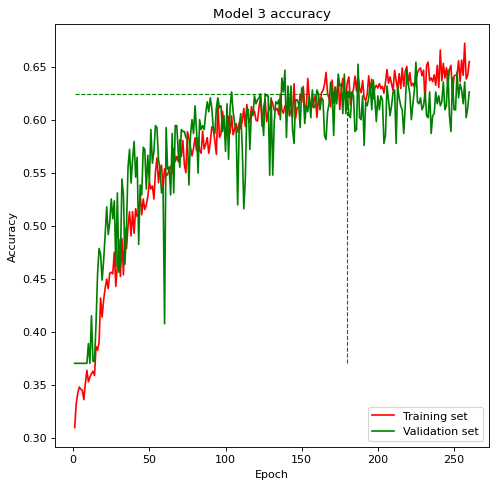

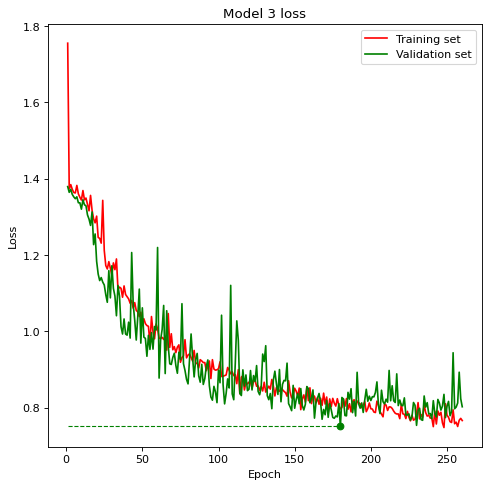

In [15]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

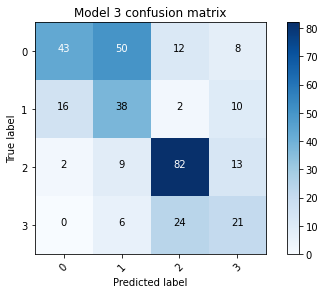

In [20]:
pred_3_classes = opt_model_3.predict_classes(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_3_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 3 confusion matrix')